# 9 GLMのベイズモデル化と事後分布の推定
GraphViz はJulia 1.0をサポートしていないため、ForneyLabを使う

In [1]:
using CSV
using DataFrames
using ForneyLab 
using GLM
using LaTeXStrings
using LinearAlgebra
using Mamba
using Plots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
df = CSV.read("data/section9.csv");
disallowmissing!(df)

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


## 9.1 例題 : 種子数のポアソン回帰 (個体差なし)

In [3]:
glm_model = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.56606  0.359949 4.35077    <1e-4
x            0.0833412 0.0683847 1.21871   0.2230


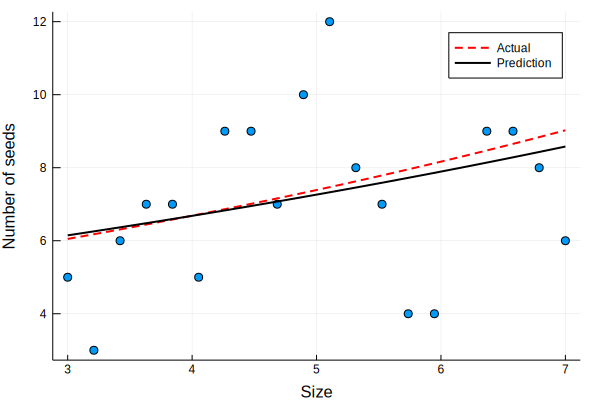

In [4]:
scatter(df.x, df.y, label = "", xlabel = "Size", ylabel = "Number of seeds")
xs = 3:0.1:7
xx = DataFrame(x = xs)
plot!(xs, exp.(1.5 .+ 0.1 .* xs), label = "Actual", linewidth = 2, 
    linestyle = :dash, linecolor = :red)
plot!(xs, predict(glm_model, xx), label = "Prediction", linewidth = 2, 
    linecolor = :black)

## 9.4 ベイズ統計モデルの事後分布の推定
### 9.4.1 ベイズ統計モデルのコーディング
\begin{align}
                y_i & \sim \text{Poisson}(\lambda_i)\\
    \log(\lambda_i) & =    \beta_1 + \beta_2 \cdot x_i\\
            \beta_1 & \sim \text{Normal}(0, 100^2)\\
            \beta_2 & \sim \text{Normal}(0, 100^2)
\end{align}
Mamba.jl ( https://mambajl.readthedocs.io/ )を使う
### モデルの作成

In [5]:
model = Model(
    y = Stochastic(1,
        (N, lambda) -> 
        (UnivariateDistribution[Poisson(lambda[i]) for i in 1:N]),
        false
    ),
    
    lambda = Logical(1,
        (x, beta) -> exp.(x * beta)
    ),
    
    beta = Stochastic(1, 
        () -> MvNormal(2, 100)
    ),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルをプロットする

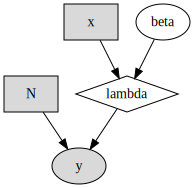

In [6]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [7]:
data = Dict{Symbol, Any}(
    :x => [ones(length(df.x)) df.x],
    :y => df.y,
    :N => length(df.x)
)

Dict{Symbol,Any} with 3 entries:
  :N => 20
  :y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6]
  :x => [1.0 3.0; 1.0 3.21053; … ; 1.0 6.78947; 1.0 7.0]

### 初期値の設定

In [8]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => ones(2),
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[1.0, 1.0],:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])
 Dict(:beta=>[1.0, 1.0],:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])
 Dict(:beta=>[1.0, 1.0],:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])

### サンプラーの設定

In [9]:
scheme = [NUTS([:beta])]

1-element Array{Sampler{Mamba.NUTSTune},1}:
 An object of type "Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), Const(##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


### MCMC シミュレーション

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 1600, burnin = 100, thin = 3, chains = 3)

MCMC Simulation of 1600 Iterations x 3 Chains...

Chain 1:   1% [0:02:26 of 0:02:27 remaining]
Chain 1:  10% [0:00:12 of 0:00:13 remaining]
Chain 1:  20% [0:00:06 of 0:00:08 remaining]
Chain 1:  30% [0:00:04 of 0:00:06 remaining]
Chain 1:  40% [0:00:03 of 0:00:05 remaining]
Chain 1:  50% [0:00:02 of 0:00:04 remaining]
Chain 1:  60% [0:00:01 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:03 remaining]
Chain 1:  80% [0:00:01 of 0:00:03 remaining]
Chain 1:  90% [0:00:00 of 0:00:03 remaining]
Chain 1: 100% [0:00:00 of 0:00:03 remaining]

Chain 2:   1% [0:00:01 of 0:00:01 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:01 of 0:00:02 remaining]
Chain 2:  30% [0:00:01 of 0:00:02 remaining]
Chain 2:  40% [0:00:01 of 0:00:02 remaining]
Chain 2:  50% [0:00:01 of 0:00:02 remaining]
Chain 2:  60% [0:00:01 of 0:00:02 remaining]
Chain 2:  70% [0:00:01 of 0:00:02 remaining]
Chain 2:  80% [0:00:00 of 0:00:02 remaining]
Chain 2:  90% [0:00:00 of 0:00:02 remaining]
Chai

Object of type "ModelChains"

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

[2.13936 -0.0648028 … 5.47056 5.39643; 2.20092 -0.0342026 … 7.16137 7.10999; … ; 0.901741 0.194945 … 9.25637 9.64416; 0.633932 0.256713 … 10.7713 11.3694]

[1.67291 0.0701775 … 8.57949 8.70718; 1.67914 0.0593435 … 8.02087 8.12171; … ; 1.28418 0.115186 … 7.89504 8.08883; 1.0438 0.170327 … 9.02706 9.35663]

[1.19207 0.165237 … 10.1142 10.4723; 2.19554 -0.0176288 … 7.97133 7.9418; … ; 1.51993 0.105703 … 9.37081 9.58168; 1.06824 0.185608 … 10.2618 10.6707]

### 9.4.3 どれだけ長くMCMCサンプリングすればいいのか？

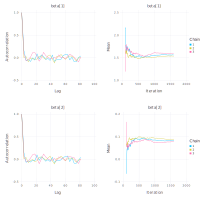

In [11]:
p = Mamba.plot(sim[:, :beta, :], [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

### Gelman-Rubin diagnostic ($\hat{R}$)の推定値

In [12]:
gelmandiag(sim[:, :beta, :], mpsrf = true, transform = true)

              PSRF 97.5%
     beta[1] 1.008 1.018
     beta[2] 1.008 1.019
Multivariate 1.007   NaN



## 9.5 MCMCサンプルから事後分布を推定
### シミュレーション結果の表示と図示

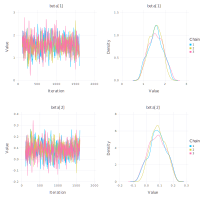

In [13]:
p = Mamba.plot(sim[:, :beta, :], legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

### 9.5.1 事後分布の統計量

In [14]:
describe(sim[:, :beta, :])

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

Empirical Posterior Estimates:
           Mean        SD       Naive SE       MCSE        ESS   
beta[1] 1.55761098 0.36760647 0.0094915583 0.0183289813 402.24406
beta[2] 0.08374666 0.06940899 0.0017921324 0.0035321713 386.14279

Quantiles:
            2.5%        25.0%       50.0%       75.0%      97.5%  
beta[1]  0.862874257 1.298632898 1.560980191 1.80836797 2.27343908
beta[2] -0.051219394 0.038266495 0.083706473 0.13195934 0.21593315



In [15]:
xs = collect(3:0.1:7)
xs_mat = [ones(length(xs)) xs]

sim_beta = sim[:, [:beta], :].value
sim_beta = reshape(permutedims(sim_beta, (2, 1, 3)), size(sim_beta, 2), :)

2×1500 Array{Float64,2}:
  2.13936     2.20092    1.63486    …  1.63475    1.51993   1.06824 
 -0.0648028  -0.0342026  0.0699437     0.0649356  0.105703  0.185608

In [16]:
beta_median = mapslices(median, sim[:, [:beta], :].value, dims = (1,3))[:]

2-element Array{Float64,1}:
 1.5609801913969197 
 0.08370647342912613

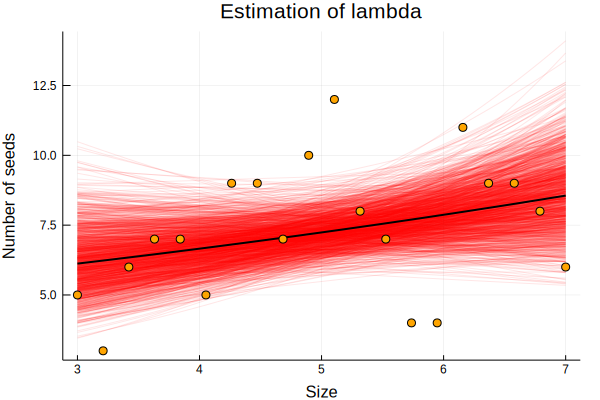

In [17]:
Plots.plot(xs, exp.(xs_mat * sim_beta), label = "", linecolor = :red, linealpha = 0.1)
Plots.plot!(xs, exp.(xs_mat * beta_median), label = "", 
            linewidth = 2, linecolor = :black)
scatter!(df.x, df.y, 
    label = "", 
    markercolor = :orange, 
    xlabel = "Size", ylabel = "Number of seeds", 
    title = "Estimation of lambda")

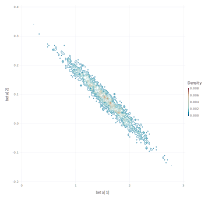

In [18]:
p = Mamba.plot(sim[:, :beta, :], :contour)
Mamba.draw(p, nrow = 1, ncol = 1)